# Image generation ipython notebook for Hybrid Image Convolution

In [1]:
# import libraries and check versions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')

pandas version: 1.3.2
numpy version: 1.20.3


## Data Importing and Wrangling

In [2]:
# import dataset
import pickle
dataset = pickle.load(open('./datasets/RML2016.10a_dict.pkl', 'rb'), encoding='latin1')

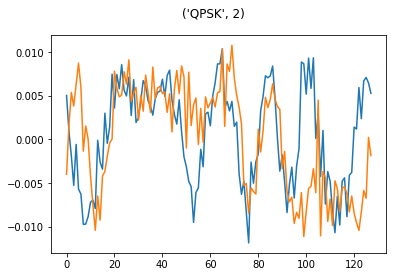

In [3]:
# plot dataset example
dataset_keys = list(dataset.keys())
x, y = dataset[dataset_keys[0]][1]

plt.figure(1)
plt.plot(x)
plt.plot(y)

plt.suptitle(dataset_keys[0])

plt.show()

In [4]:
# process raw data into usable format
columns = ['signal_type', 'SNR', 'samples']

# split dataset into individual records
temp = []
for k, v0 in dataset.items():
    data = [[k[0], k[1], v1] for v1 in v0]
    temp += data
    
# turn transformed data into dataframe
df = pd.DataFrame(temp, columns = columns)

# process dtypes of columns in dataframe
df = df.astype({'signal_type' : 'string'})

# filter out low SNR data
df = df[df['SNR'] >= 2]

print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99000 entries, 0 to 218999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   signal_type  99000 non-null  string
 1   SNR          99000 non-null  int64 
 2   samples      99000 non-null  object
dtypes: int64(1), object(1), string(1)
memory usage: 3.0+ MB
None


,signal_type,SNR,samples
0,QPSK,2,"[[-0.0059014712, -0.0023458179, -0.00074506126..."
1,QPSK,2,"[[0.0050326153, 0.00094379985, -0.0018932355, ..."
2,QPSK,2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0..."


## EDA

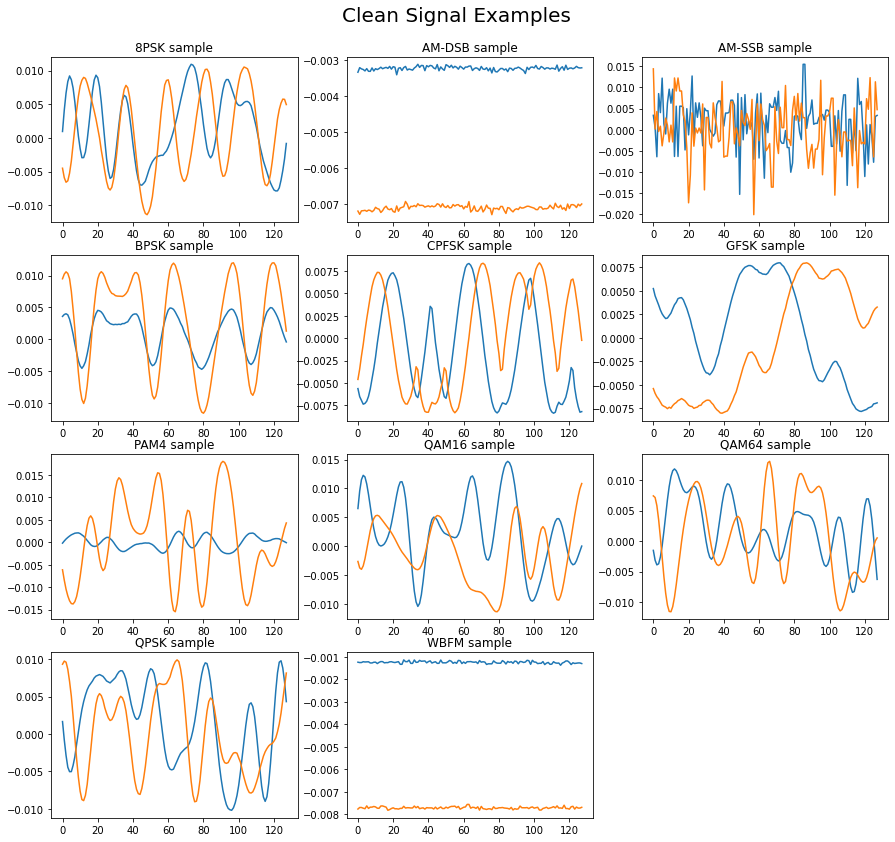

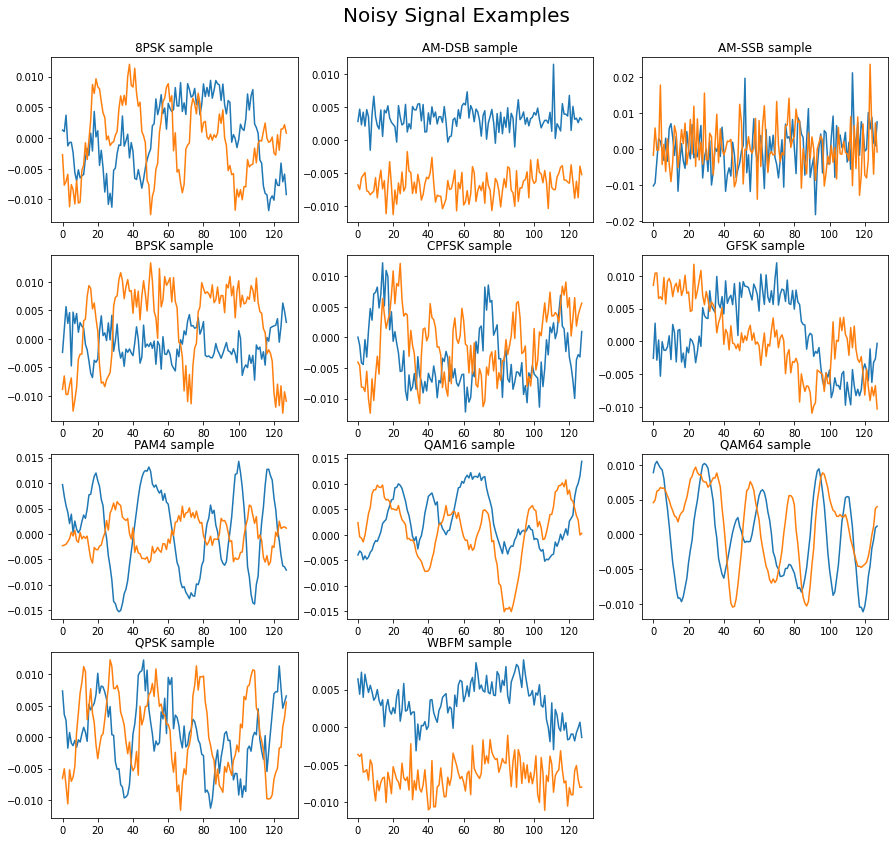

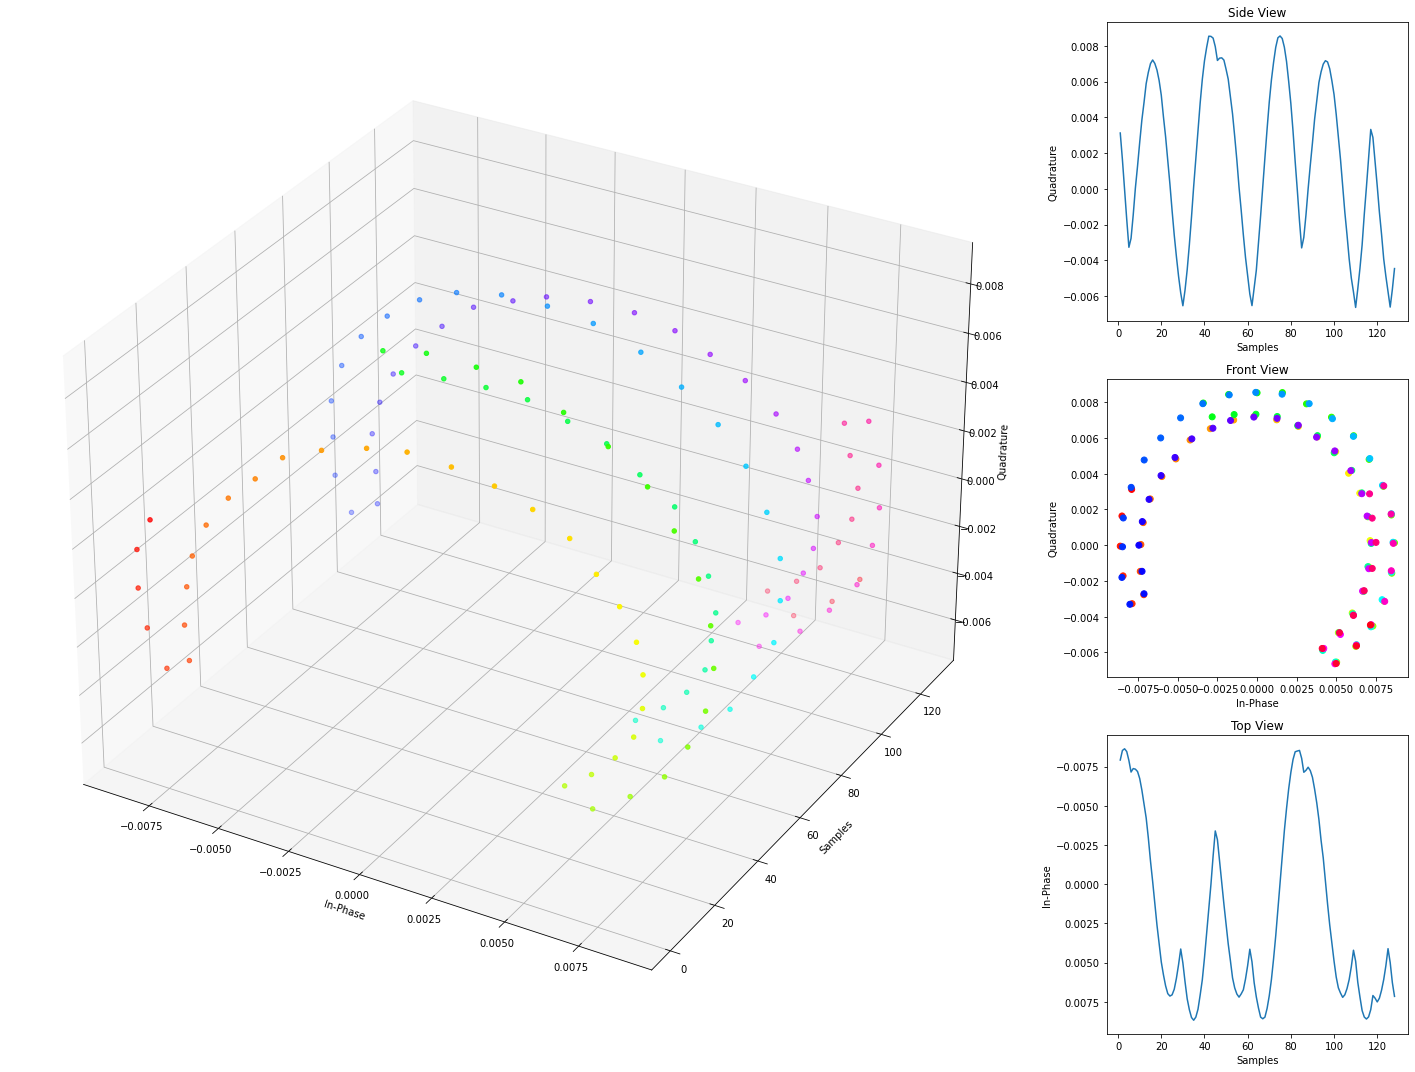

In [5]:
# plot out eda graphs
# plot out one of each clean signal
df_p1 = df[df['SNR'] == 18].sort_values('signal_type')
fig1 = plt.figure(figsize=(15, 14))
fig1.suptitle('Clean Signal Examples', y=0.93, fontsize=20)

for i, st in enumerate(df_p1['signal_type'].unique()):
    # extract random sample from plot df
    sample = df_p1[df_p1['signal_type'] == st]['samples'].sample().iloc[0]
        
    # generate axes
    ax = fig1.add_subplot(4, 3, i+1)
    
    # plot onto subplot
    ax.plot(sample[0])
    ax.plot(sample[1])
    
    ax.set_title(f'{st} sample')
    
# plot out one of each noisy signal
df_p2 = df[df['SNR'] == 2].sort_values('signal_type')
fig2 = plt.figure(figsize=(15, 14))
fig2.suptitle('Noisy Signal Examples', y=0.93, fontsize=20)

for i, st in enumerate(df_p2['signal_type'].unique()):
    # extract random example from plot df
    sample = df_p2[df_p2['signal_type'] == st]['samples'].sample().iloc[0]
    
    # generate axes
    ax = fig2.add_subplot(4, 3, i+1)
    
    # plot onto subplot
    ax.plot(sample[0])
    ax.plot(sample[1])
    
    ax.set_title(f'{st} sample')

# test plot
fig3 = plt.figure(figsize=(20, 15))
gs = fig3.add_gridspec(3, 4)
ax = fig3.add_subplot(gs[:3, :3], projection='3d')

x, z = df_p1[df_p1['signal_type'] == 'CPFSK']['samples'].sample().iloc[0]
y = np.arange(1, 129)

ax.scatter(x, y, z, c=y, cmap='hsv')
ax.set_xlabel('In-Phase')
ax.set_ylabel('Samples')
ax.set_zlabel('Quadrature')

# fig4 = plt.figure(figsize=(15, 5))

ax1 = fig3.add_subplot(gs[0, 3])
ax1.plot(y, z)
ax1.set_xlabel('Samples')
ax1.set_ylabel('Quadrature')
ax1.set_title('Side View')

ax2 = fig3.add_subplot(gs[1, 3])
ax2.scatter(x, z, c=y, cmap='hsv')
ax2.set_xlabel('In-Phase')
ax2.set_ylabel('Quadrature')
ax2.set_title('Front View')

ax3 = fig3.add_subplot(gs[2, 3])
ax3.plot(y, x)
ax3.set_xlabel('Samples')
ax3.set_ylabel('In-Phase')
ax3.set_title('Top View')
ax3.invert_yaxis()


plt.tight_layout()
plt.show()

## Data Preparation for Training

In [6]:
# generate signal tags for classification
signal_tags = {st : tag for tag, st in enumerate(sorted(df['signal_type'].unique()))}

tag_list = [signal_tags[i] for i in df['signal_type'].values]
df['tag'] = tag_list

df.head(3)

,signal_type,SNR,samples,tag
0,QPSK,2,"[[-0.0059014712, -0.0023458179, -0.00074506126...",9
1,QPSK,2,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",9
2,QPSK,2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",9


In [7]:
signal_tags

{'8PSK': 0,
 'AM-DSB': 1,
 'AM-SSB': 2,
 'BPSK': 3,
 'CPFSK': 4,
 'GFSK': 5,
 'PAM4': 6,
 'QAM16': 7,
 'QAM64': 8,
 'QPSK': 9,
 'WBFM': 10}

### Image generation

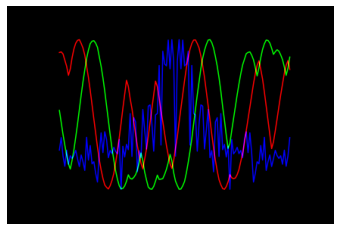

In [16]:
# cell to test logic for image generation
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
import os

# rf magic
i, q = df_p1[df_p1['signal_type'] == 'CPFSK']['samples'].sample().iloc[0]

PSD = (np.abs(np.fft.fft(i))/128)**2
PSD_log = 10.0*np.log10(PSD)
PSD_shifted = np.fft.fftshift(PSD_log)

temp = []
for graph in [i, q, PSD_shifted]:
    fig = Figure()
    canvas = FigureCanvas(fig)
    ax = fig.subplots()
    ax.plot(graph)
    ax.axis('off')

    canvas.draw()
    X = np.array(canvas.renderer.buffer_rgba())[:, :, 3]
        
    temp.append(X)

temp = np.moveaxis(np.array(temp), 0, -1)
plt.imshow(temp)
plt.axis('off')

if not os.path.exists(f'./datasets/images'):
    os.makedirs('./datasets/images')
plt.savefig('./datasets/images/test.png', bbox_inches='tight')    

In [30]:
# batch generate images
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas

from IPython.display import display
import os

# get df size
df_size = df.shape[0]

print(f'Generating {df_size} images')
dh = display('', display_id=True)

for (it, row) in df.reset_index().iterrows():
    i, q = row['samples']
    
    # generate PSD
    psd = np.fft.fftshift(10.0*np.log10((np.abs(np.fft.fft(i))/128)**2))
    
    # plot graphs, convert to hybrid images
    temp = []
    for graph in [i, q, psd]:
        fig = Figure()
        canvas = FigureCanvas(fig)
        ax = fig.subplots()
        ax.plot(graph)
        ax.axis('off')

        canvas.draw()
        X = np.array(canvas.renderer.buffer_rgba())[:, :, 3]

        temp.append(X)

    temp = np.moveaxis(np.array(temp), 0, -1)
    
    # save images to disk for later use
    directory = f'./datasets/images/{row["signal_type"]}'
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.imsave(f'{directory}/{row["signal_type"]}_{row["SNR"]}_{it}.png', temp/255)

    
    if it % 100 == 0:
        dh.update(f'{it}/{df_size} images generated')

Generating 99000 images


'98900/99000 images generated'